# Factor analysis of survVoice Quality Analysis
**Author:** Jim Maddock  
**Last Updated:** 7-17-19  
**Dscription:** Notebook specifically for factor analysis of the Voice Quality survey

In [15]:
# load packages
require(ggrepel)
require(gridExtra)
require(grid)
require(MASS)
require(ggplot2)
require(forcats)
require(psych)
require(reshape2)

if(!require(wesanderson)){install.packages("wesanderson")}
if(!require(EMT)){install.packages("EMT")}
if(!require(rcompanion)){install.packages("rcompanion")}

In [16]:
toBinary = function (column) {
    column = factor(column, labels = c(1))
    column = as.numeric(column)
    column[is.na(column)] = 0
    return(column)
}

In [17]:
# load data from file
load("~/Desktop/Rdata")
data = data[, -c(1:21, 24, 34, 37, 48, 55, 63)]
colnames(data) = c("MID", "audio.paused", "page.seconds", "rate.experience", "rate.speed", "rate.again",
                   "voice.easy", "voice.monotone", "voice.natural", "voice.no_emotion", "voice.focus",
                   "voice.all", "voice.none", "voice.other",
                   "check1", "check2", "check3", "check4", "check5", "check6", "check7", 
                   "age", "gender",
                   "race.asian", "race.hawaiian", "race.aa", "race.cc", "race.latin", "race.indian", "race.other",
                   "income", "state", "device", "device.other", "headphones", "voice")

data = as.data.frame(lapply(data, function (x) if (is.factor(x)) factor(x) else x))

data$check1 = ifelse(data$check1 == "An article about dealing with stress", 1, 0)
data$check2 = ifelse(data$check2 == "His constant need for success", 1, 0)
data$check3 = ifelse(data$check3 == "It oxygenates your brain", 1, 0)
data$check4 = ifelse(data$check4 == "2 and 3", 1, 0)
data$check5 = ifelse(data$check5 == "Ask yourself if a thought is really true.", 1, 0)
data$check6 = ifelse(data$check6 == "Everything has to have a purpose", 1, 0)
data$check7 = ifelse(data$check7 == "Do less than you want to do", 1, 0)

In [18]:
# create factors
data$gender = factor(data$gender, levels = c("", "Man" , "These don't describe me",   "Woman"),
              labels = c("NA", "Male", "Other", "Female"))
data$grade = round(rowMeans(data[, 15:21], na.rm = TRUE),2)*10

data$rate.speed = ordered(data$rate.speed, levels = c("Much too fast", "Too fast", "Just right",
                                                      "Too slow", "Much too slow"))
                          
data$rate.experience = ordered(data$rate.experience, levels = c("Excellent", "Good", "OK", "Poor", "Very poor"))
data$voice.easy = toBinary(data$voice.easy)
data$voice.monotone = abs(toBinary(data$voice.monotone) - 1)
data$voice.natural = toBinary(data$voice.natural)
data$voice.no_emotion = abs(toBinary(data$voice.no_emotion) -1)
data$voice.focus = toBinary(data$voice.focus)


#,'voice.monotone','voice.natural','voice.no_emotion','voice.focus'

In [19]:
# create collapsed factors
data$rate.experience.simple = data$rate.experience
levels(data$rate.experience.simple) = c('Good','Good','OK','Poor','Poor')

data$rate.speed.simple = data$rate.speed
levels(data$rate.speed.simple) = c('Too fast','Too fast','Just right','Too slow','Too slow')

In [20]:
# all TTS voices
group_names.voice = c(
  "MozillaTTS:LJSpeech" = paste("MozillaTTS:LJSpeech (", nrow(data[data$voice == "MozillaTTS:LJSpeech",]) ,")", sep = ""),
  "Google A" = paste("Google A (", nrow(data[data$voice == "Google A",]) ,")", sep = ""),
  "Google C" = paste("Google C (", nrow(data[data$voice == "Google C",]) ,")", sep = ""),
  "Polly Joana" = paste("Polly Joana (", nrow(data[data$voice == "Polly Joana",]) ,")", sep = ""),
  "Polly Matthew" = paste("Polly Matthew (", nrow(data[data$voice == "Polly Matthew",]) ,")", sep = ""),
  "Polly Sally" = paste("Polly Sally (", nrow(data[data$voice == "Polly Sally",]) ,")", sep = ""),
  "Voicery Nichole" = paste("Voicery Nichole (", nrow(data[data$voice == "Voicery Nichole",]) ,")", sep = ""),
  "Android UK Male" = paste("Android UK Male (", nrow(data[data$voice == "Android UK Male",]) ,")", sep = ""),
  "iOS Female" = paste("iOS Female (", nrow(data[data$voice == "iOS Female",]) ,")", sep = ""),
  "Mozilla TTS:Nancy" = paste("Mozilla TTS:Nancy (", nrow(data[data$voice == "Mozilla TTS:Nancy",]) ,")", sep = ""),
  "Mozilla TTS:Nancy2" = paste("Mozilla TTS:Nancy2 (", nrow(data[data$voice == "Mozilla TTS:Nancy2",]) ,")", sep = ""),
  "Judy Wave2" = paste("Judy Wave2 (", nrow(data[data$voice == "Judy Wave2",]) ,")", sep = ""),
  "Judy Wave1" = paste("Judy Wave1 (", nrow(data[data$voice == "Judy Wave1",]) ,")", sep = ""),
  "Judy GL2" = paste("Judy GL2 (", nrow(data[data$voice == "Judy GL2",]) ,")", sep = ""),
  "Judy GL1" = paste("Judy GL1 (", nrow(data[data$voice == "Judy GL1",]) ,")", sep = ""),
  ".Jofish" = paste(".Jofish (", nrow(data[data$voice == ".Jofish",]) ,")", sep = ""),
  ".Janice" = paste(".Janice (", nrow(data[data$voice == ".Janice",]) ,")", sep = ""),
  ".Abe" = paste(".Abe (", nrow(data[data$voice == ".Abe",]) ,")", sep = ""),
  "Common Voice" = paste("Common Voice (", nrow(data[data$voice == "Common Voice",]) ,")", sep = ""),
  "Mac Default" = paste("Mac Default (", nrow(data[data$voice == "Mac Default",]) ,")", sep = ""),
  "Text only" = paste("Text only (", nrow(data[data$voice == "Text only",]) ,")", sep = ""),
  "Windows Female" = paste("Windows Female (", nrow(data[data$voice == "Windows Female",]) ,")", sep = ""),
  "Windows Male" = paste("Windows Male (", nrow(data[data$voice == "Windows Male",]) ,")", sep = "")
)

# only controls (human, text), Mozilla TTS, and Amazon Polly
group_names.voice.polly_vs_deep = c(
  "MozillaTTS:LJSpeech" = paste("MozillaTTS:LJSpeech (", nrow(data[data$voice == "MozillaTTS:LJSpeech",]) ,")", sep = ""),
  "Mozilla TTS:Nancy" = paste("Mozilla TTS:Nancy (", nrow(data[data$voice == "Mozilla TTS:Nancy",]) ,")", sep = ""),
  "Mozilla TTS:Nancy2" = paste("Mozilla TTS:Nancy2 (", nrow(data[data$voice == "Mozilla TTS:Nancy2",]) ,")", sep = ""),
  "Judy Wave2" = paste("Judy Wave2 (", nrow(data[data$voice == "Judy Wave2",]) ,")", sep = ""),
  "Judy Wave1" = paste("Judy Wave1 (", nrow(data[data$voice == "Judy Wave1",]) ,")", sep = ""),
  "Judy GL2" = paste("Judy GL2 (", nrow(data[data$voice == "Judy GL2",]) ,")", sep = ""),
  "Judy GL1" = paste("Judy GL1 (", nrow(data[data$voice == "Judy GL1",]) ,")", sep = ""),
  "Polly Joana" = paste("Polly Joana (", nrow(data[data$voice == "Polly Joana",]) ,")", sep = ""),
  "Polly Matthew" = paste("Polly Matthew (", nrow(data[data$voice == "Polly Matthew",]) ,")", sep = ""),
  "Polly Sally" = paste("Polly Sally (", nrow(data[data$voice == "Polly Sally",]) ,")", sep = ""),
  ".Jofish" = paste(".Jofish (", nrow(data[data$voice == ".Jofish",]) ,")", sep = ""),
  ".Janice" = paste(".Janice (", nrow(data[data$voice == ".Janice",]) ,")", sep = ""),
  ".Abe" = paste(".Abe (", nrow(data[data$voice == ".Abe",]) ,")", sep = ""),
  "Text only" = paste("Text only (", nrow(data[data$voice == "Text only",]) ,")", sep = "")
)

group_names.voice.type = c(
  "MozillaTTS:LJSpeech" = "Mozilla TTS",
  "Mozilla TTS:Nancy" = "Mozilla TTS",
  "Mozilla TTS:Nancy2" = "Mozilla TTS",
  "Judy Wave2" = "Mozilla TTS",
  "Judy Wave1" = "Mozilla TTS",
  "Judy GL2" = "Mozilla TTS",
  "Judy GL1" = "Mozilla TTS",
  "Polly Joana" = "Amazon Polly",
  "Polly Matthew" = "Amazon Polly",
  "Polly Sally" = "Amazon Polly",
  ".Jofish" = "Human",
  ".Janice" = "Human",
  ".Abe" = "Human",
  "Text only" = "Text"
)

# gender categories
group_names.gender = c(
  "Male" = paste("Male (", nrow(data[data$gender == "Male",]) ,")"),
  "Female" = paste("Female (", nrow(data[data$gender == "Female",]) ,")")
)

# headphones (y/n)
group_names.headphone = c(
  "No" = paste("No headphones (", nrow(data[data$headphones == "No",]) ,")"),
  "Yes" = paste("Headphones (", nrow(data[data$headphones == "Yes",]) ,")")
)

In [21]:
data = subset(data, voice %in% names(group_names.voice))

In [22]:
alpha(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')], check.keys=TRUE)


Reliability analysis   
Call: alpha(x = data[c("voice.easy", "voice.monotone", "voice.natural", 
    "voice.no_emotion", "voice.focus")], check.keys = TRUE)

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean   sd median_r
      0.63      0.64    0.65      0.26 1.7 0.018 0.43 0.31     0.18

 lower alpha upper     95% confidence boundaries
0.6 0.63 0.67 

 Reliability if an item is dropped:
                 raw_alpha std.alpha G6(smc) average_r S/N alpha se var.r med.r
voice.easy            0.64      0.64    0.62      0.31 1.8    0.018 0.045 0.309
voice.monotone        0.55      0.56    0.55      0.24 1.3    0.023 0.034 0.179
voice.natural         0.53      0.53    0.55      0.22 1.1    0.024 0.051 0.091
voice.no_emotion      0.54      0.55    0.53      0.23 1.2    0.023 0.027 0.179
voice.focus           0.62      0.63    0.61      0.30 1.7    0.019 0.051 0.301

 Item statistics 
                    n raw.r std.r r.cor r.drop mean   sd
voice.easy       1090  0.55  0.54  0.36   0.26

In [23]:
cor(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')])

,voice.easy,voice.monotone,voice.natural,voice.no_emotion,voice.focus
voice.easy,1.00000000,0.06707201,0.1706319,0.05451296,0.44116266
voice.monotone,0.06707201,1.00000000,0.4320988,0.56684013,0.09516221
voice.natural,0.17063188,0.43209879,1.0000000,0.49031562,0.18669021
voice.no_emotion,0.05451296,0.56684013,0.4903156,1.00000000,0.08607051
voice.focus,0.44116266,0.09516221,0.1866902,0.08607051,1.00000000


Importance of components:
                          Comp.1    Comp.2    Comp.3    Comp.4     Comp.5
Standard deviation     1.4502973 1.1632244 0.7525457 0.7447285 0.65007785
Proportion of Variance 0.4206724 0.2706182 0.1132650 0.1109241 0.08452024
Cumulative Proportion  0.4206724 0.6912906 0.8045557 0.9154798 1.00000000


Loadings:
                 Comp.1 Comp.2 Comp.3 Comp.4 Comp.5
voice.easy        0.253  0.658  0.301  0.641       
voice.monotone    0.527 -0.270 -0.442  0.322 -0.591
voice.natural     0.534         0.684 -0.431 -0.233
voice.no_emotion  0.543 -0.291 -0.139         0.770
voice.focus       0.279  0.635 -0.476 -0.540       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5
SS loadings       1.0    1.0    1.0    1.0    1.0
Proportion Var    0.2    0.2    0.2    0.2    0.2
Cumulative Var    0.2    0.4    0.6    0.8    1.0

Comp.1,Comp.2,Comp.3,Comp.4,Comp.5
-0.7730146,-1.1406315,-0.599391610,0.35558946,-1.25522566
2.0406709,-0.5928541,1.286764723,0.83415947,-0.14485913
-0.7572445,1.9985069,-0.073541606,-0.09768375,0.06658569
1.3851329,0.8746063,-1.236420347,0.72787366,0.42825342
-0.7572445,1.9985069,-0.073541606,-0.09768375,0.06658569
1.5496595,1.2298697,1.210240046,-0.90135396,1.07816688
-0.7572445,1.9985069,-0.073541606,-0.09768375,0.06658569
-1.2640261,0.6820924,-0.675916288,-1.37992397,-0.03219966
-0.7407691,-1.1824399,0.006687272,-0.10897992,1.47087497
0.3300670,1.4156524,-0.351941535,0.08281026,1.61046987


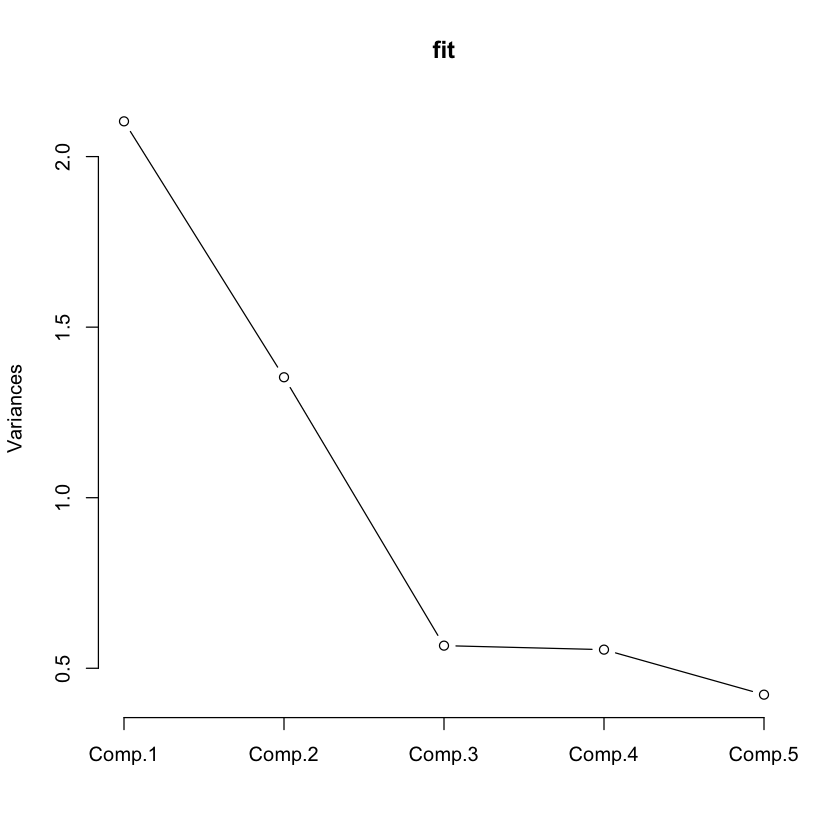

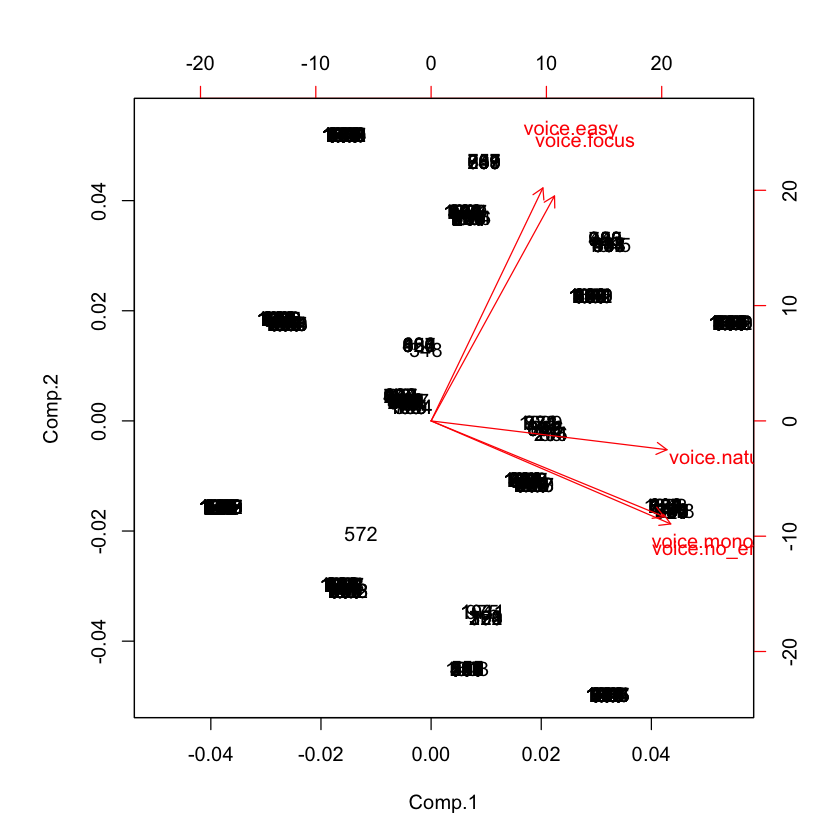

In [24]:
fit <- princomp(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')], cor=TRUE)
summary(fit) # print variance accounted for
loadings(fit) # pc loadings
plot(fit,type="lines") # scree plot
fit$scores # the principal components
biplot(fit) 

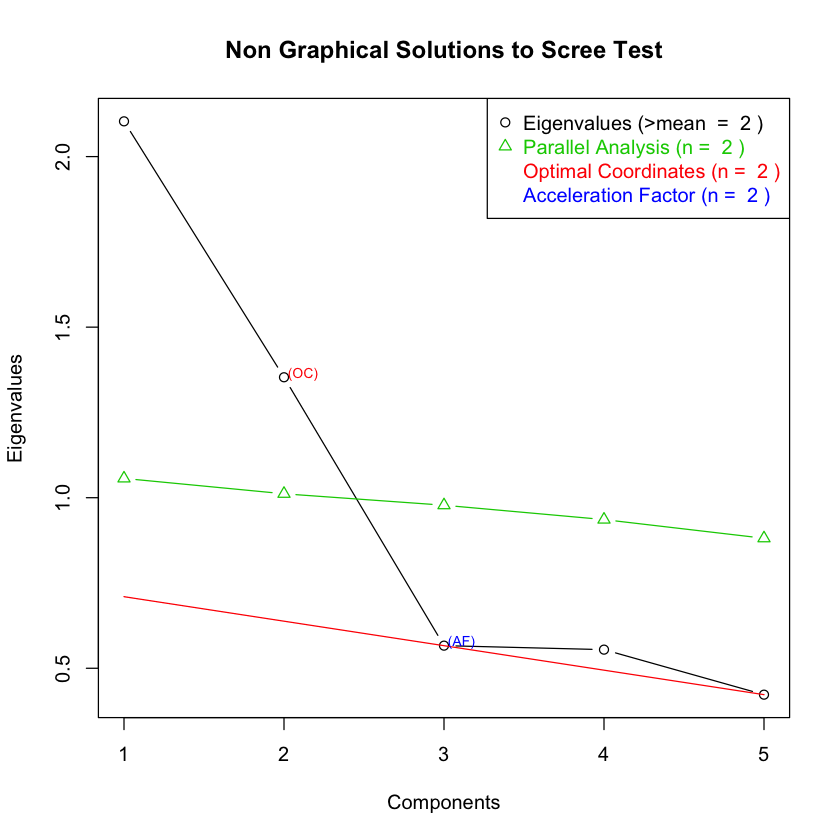

In [25]:
# Determine Number of Factors to Extract
library(nFactors)
ev <- eigen(cor(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')])) # get eigenvalues
ap <- parallel(subject=nrow(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')]),var=ncol(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')]),
  rep=100,cent=.05)
nS <- nScree(x=ev$values, aparallel=ap$eigen$qevpea)
plotnScree(nS)


Call:
factanal(x = data[c("voice.easy", "voice.monotone", "voice.natural",     "voice.no_emotion", "voice.focus")], factors = 2, rotation = "varimax")

Uniquenesses:
      voice.easy   voice.monotone    voice.natural voice.no_emotion 
            0.53             0.51             0.59             0.35 
     voice.focus 
            0.58 

Loadings:
                 Factor1 Factor2
voice.monotone   0.70           
voice.natural    0.60           
voice.no_emotion 0.81           
voice.easy               0.68   
voice.focus              0.64   

               Factor1 Factor2
SS loadings       1.52    0.92
Proportion Var    0.30    0.18
Cumulative Var    0.30    0.49

Test of the hypothesis that 2 factors are sufficient.
The chi square statistic is 0 on 1 degree of freedom.
The p-value is 0.945 


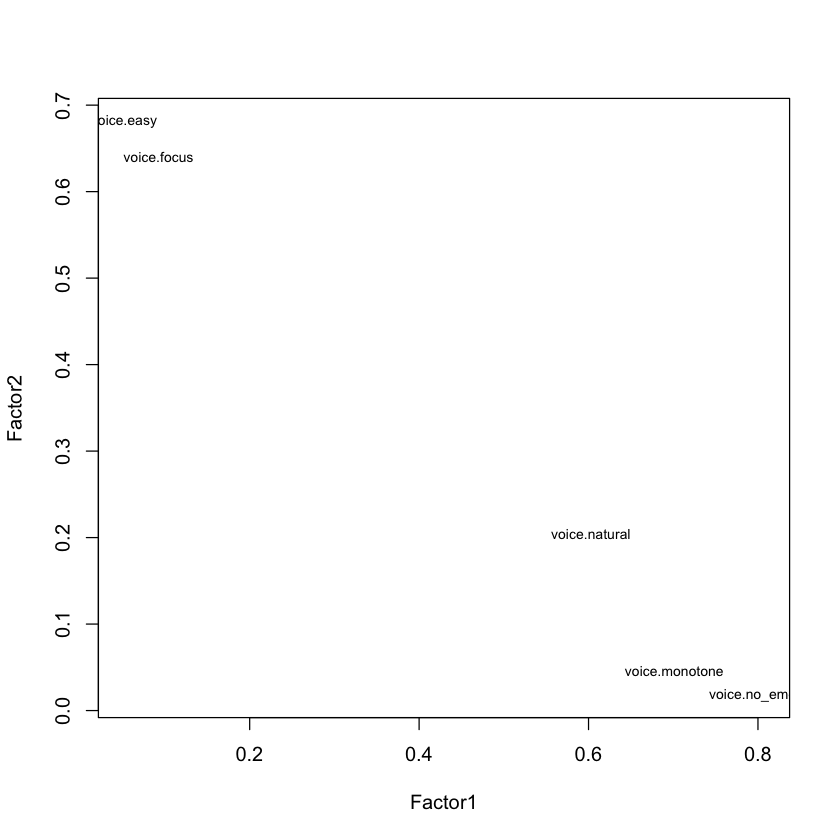

In [26]:
# Maximum Likelihood Factor Analysis
# entering raw data and extracting 3 factors,
# with varimax rotation
fit <- factanal(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')], 2, rotation="varimax")
print(fit, digits=2, cutoff=.3, sort=TRUE)
# plot factor 1 by factor 2
load <- fit$loadings[,1:2]
plot(load,type="n") # set up plot
text(load,labels=names(data[c('voice.easy','voice.monotone','voice.natural','voice.no_emotion','voice.focus')]),cex=.7) # add variable names 

Using voice as id variables


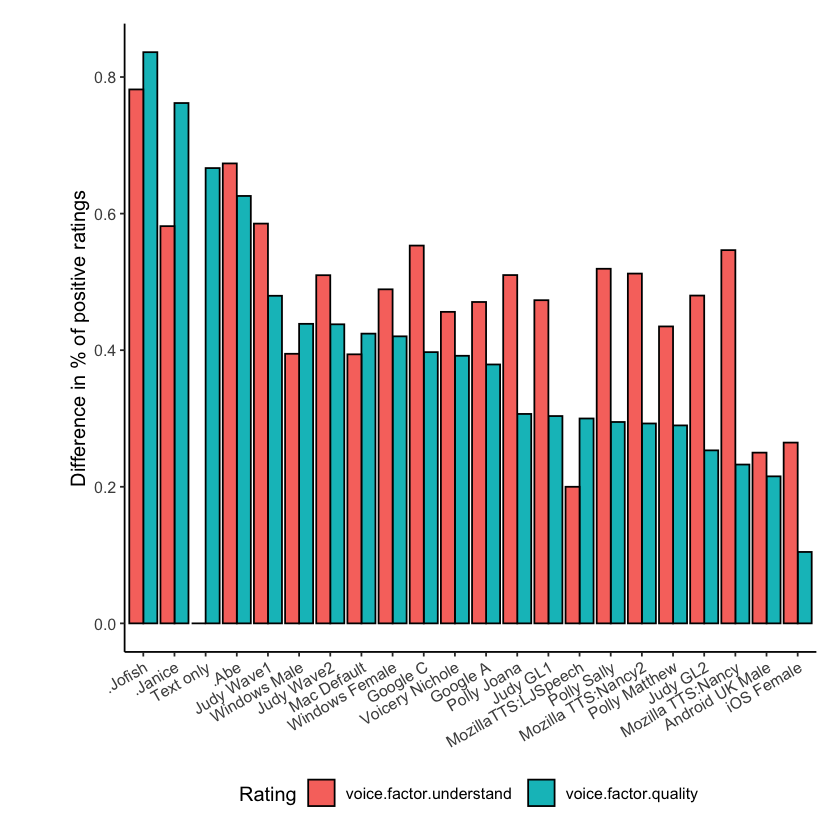

In [27]:
#data
data$voice.factor.understand = rowMeans(data[c('voice.easy','voice.focus')])
data$voice.factor.quality = rowMeans(data[c('voice.natural','voice.monotone','voice.no_emotion')])
temp = merge(aggregate(voice.factor.understand ~ voice, data=data, FUN = "mean"),aggregate(voice.factor.quality ~ voice, data=data, FUN = "mean"),by='voice')
temp = melt(temp)

rank = subset(temp, variable == "voice.factor.quality")
rank = rank[order(-rank$value),]
rank$rank = rank(rank$value)
temp = merge(temp,rank[c("voice","rank")],by="voice")

ggplot(temp, aes(x = reorder(voice,-rank), y = value, fill = variable)) +
  geom_bar(stat="identity", color = "black", position=position_dodge()) + 
  labs(y = "Difference in % of positive ratings") +
  #facet_wrap( ~ Var2, labeller = as_labeller(c("Good","Poor"))) +
  theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = "Rating")) +
  scale_colour_brewer(palette = "PRGn")

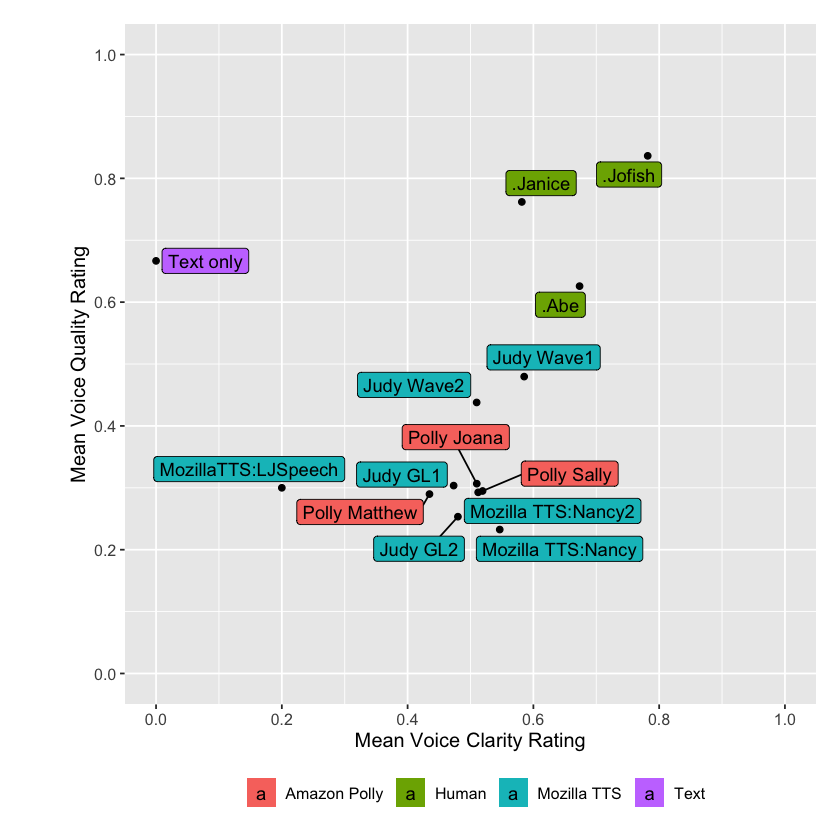

In [66]:
data$voice.factor.understand = rowMeans(data[c('voice.easy','voice.focus')])
data$voice.factor.quality = rowMeans(data[c('voice.natural','voice.monotone','voice.no_emotion')])
temp = merge(aggregate(voice.factor.understand ~ voice, data=data, FUN = "mean"),aggregate(voice.factor.quality ~ voice, data=data, FUN = "mean"),by='voice')
temp = merge(temp,group_names.voice.type,by.x='voice',by.y=0)


ggplot(temp, aes(x = voice.factor.understand, y = voice.factor.quality, geom_text = voice)) +
  geom_point() + 
  labs(x = "Mean Voice Clarity Rating", y = "Mean Voice Quality Rating") +
  geom_label_repel(aes(label=voice, fill=y)) + 
  #facet_wrap( ~ Var2, labeller = as_labeller(c("Good","Poor"))) +
  #theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        #axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        #axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = element_blank())) +
  #scale_colour_brewer(palette = "PRGn") + 
  scale_y_continuous(limits=c(0,1),breaks=seq(0,1,.2)) +
  scale_x_continuous(limits=c(0,1),breaks=seq(0,1,.2))

In [55]:
print(paste("corr with all data points: ",cor(data$voice.factor.understand,data$voice.factor.quality)),sep="")

temp = subset(data, data$voice != "Text only")
print(paste("corr without text only: ",cor(temp$voice.factor.understand,temp$voice.factor.quality)),sep="")

temp = subset(data, !(data$voice %in% c('.Jofish','.Janice','.Abe','Text only')))
print(paste("corr without text only: ",cor(temp$voice.factor.understand,temp$voice.factor.quality)),sep="")

[1] "corr with all data points:  0.15438986758418"
[1] "corr without text only:  0.199485318016139"
[1] "corr without text only:  0.0957172724436039"


In [65]:

temp = merge(aggregate(voice.factor.understand ~ voice, data=data, FUN = "mean"),aggregate(voice.factor.quality ~ voice, data=data, FUN = "mean"),by='voice')
#temp = merge(temp,group_names.voice.type,by.x='voice',by.y=0)
#temp = subset(temp, !(temp$voice %in% c('.Jofish','.Janice','.Abe','Text only')))
temp = subset(temp, !(temp$voice %in% c('Text only')))
rank = temp
rank = rank[order(-rank$voice.factor.understand),]
rank$rank = rank(-rank$voice.factor.understand)
temp = merge(temp,rank[c("voice","rank")],by="voice")
rank = temp
rank = rank[order(-rank$voice.factor.quality),]
rank$rank = rank(-rank$voice.factor.quality)
temp = merge(temp,rank[c("voice","rank")],by="voice")
temp

voice,voice.factor.understand,voice.factor.quality,rank.x,rank.y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
.Abe,0.6734694,0.6258503,2,3
.Janice,0.5816327,0.7619048,4,2
.Jofish,0.7818182,0.8363636,1,1
Android UK Male,0.2500000,0.2152778,20,20
Google A,0.4705882,0.3790850,14,11
Google C,0.5531915,0.3971631,5,9
iOS Female,0.2647059,0.1045752,19,21
Judy GL1,0.4732143,0.3035714,13,13
Judy GL2,0.4800000,0.2533333,12,18


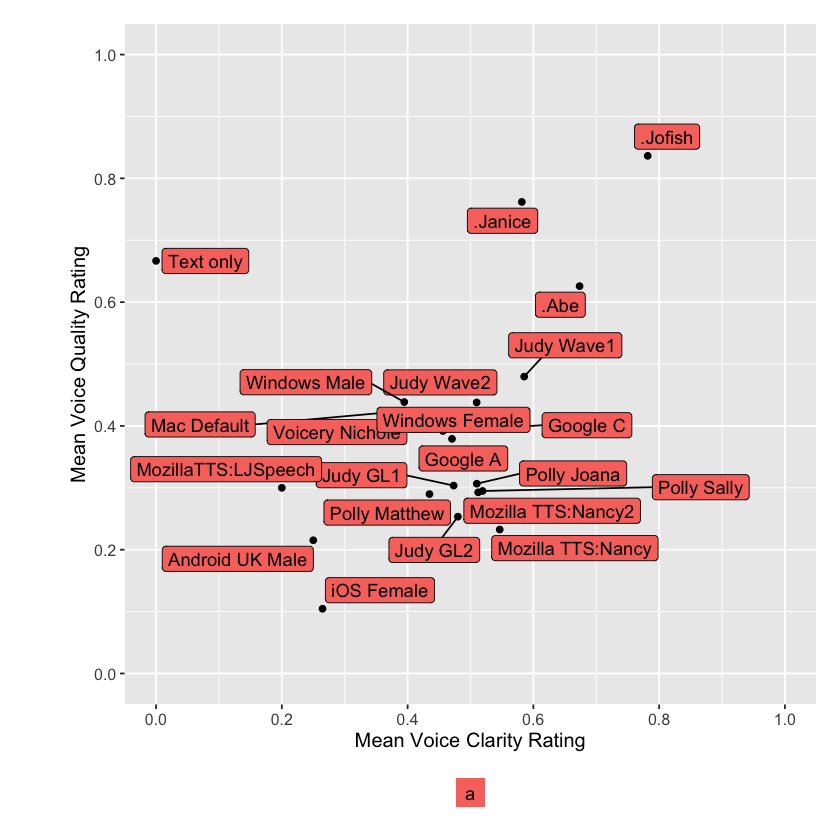

In [67]:
data$voice.factor.understand = rowMeans(data[c('voice.easy','voice.focus')])
data$voice.factor.quality = rowMeans(data[c('voice.natural','voice.monotone','voice.no_emotion')])
temp = merge(aggregate(voice.factor.understand ~ voice, data=data, FUN = "mean"),aggregate(voice.factor.quality ~ voice, data=data, FUN = "mean"),by='voice')
#temp = merge(temp,group_names.voice.type,by.x='voice',by.y=0)


ggplot(temp, aes(x = voice.factor.understand, y = voice.factor.quality, geom_text = voice)) +
  geom_point() + 
  labs(x = "Mean Voice Clarity Rating", y = "Mean Voice Quality Rating") +
  geom_label_repel(aes(label=voice, fill="")) + 
  #facet_wrap( ~ Var2, labeller = as_labeller(c("Good","Poor"))) +
  #theme_classic() + 
  theme(plot.margin=unit(c(.5,.5,.5,1.5),"cm"),
        text = element_text(size=12),
        #axis.text.x = element_text(angle = 30, hjust = 1, vjust = 1),
        #axis.title.y = element_blank(),
        #axis.title.x = element_blank(),
        strip.background = element_blank(),
        panel.spacing = unit(3, "lines"),
        legend.position = "bottom") +
  guides(fill = guide_legend(title = element_blank())) +
  #scale_colour_brewer(palette = "PRGn") + 
  scale_y_continuous(limits=c(0,1),breaks=seq(0,1,.2)) +
  scale_x_continuous(limits=c(0,1),breaks=seq(0,1,.2))